# Process Image Data for Training

The approach used here is a bit of overkill. Used pytorch dataset/dataloader in order to process the original data images and reduce their size to create the training data. Could have done the same probably much more simply just by using cv2 or other methods. But at least this gave some additional practice in creating Datasets and user DataLoader.

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
%matplotlib inline

In [2]:
pwd

'/home/ubuntu/super-resolution/notebooks'

In [7]:
# If not done already, downloaded and extract the original images by executing the following script
# /home/ubuntu/super-resolution/download_and_extract_images.sh

In [5]:
ORIG_IMAGE_DIR = '/home/ubuntu/data/super-resolution/orig/JPEGImages'

#print(os.listdir(ORIG_IMAGE_DIR))
len(os.listdir(ORIG_IMAGE_DIR))

5011

## Create new image files from original images

In [8]:
# Dataset of original images

class ImageDataset(Dataset):
    def __init__(self, images_folder_path, final_image_resolution=None, transform=None):
        super().__init__()
        self.final_image_resolution = final_image_resolution
        self.images_folder_path = images_folder_path
        self.transform = transform
        self.image_files = os.listdir(self.images_folder_path)
        

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        filename = self.image_files[idx]
        image_path = os.path.join(self.images_folder_path, self.image_files[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        if not self.transform is None:
            img = self.transform(img)      
        return filename, img
        

### Show some images with the transforms that will be applied

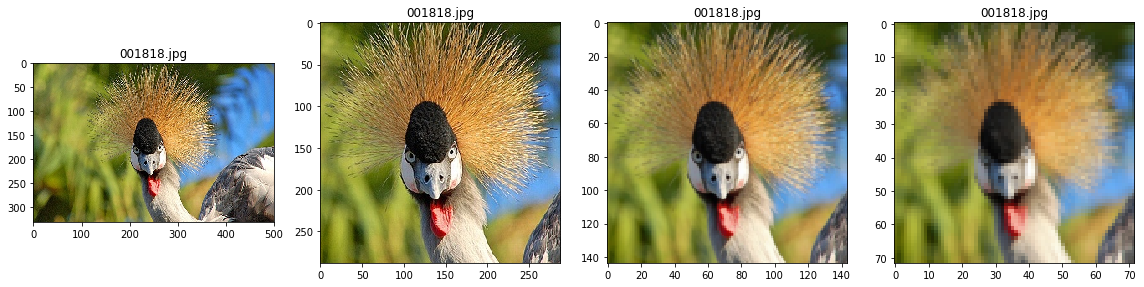

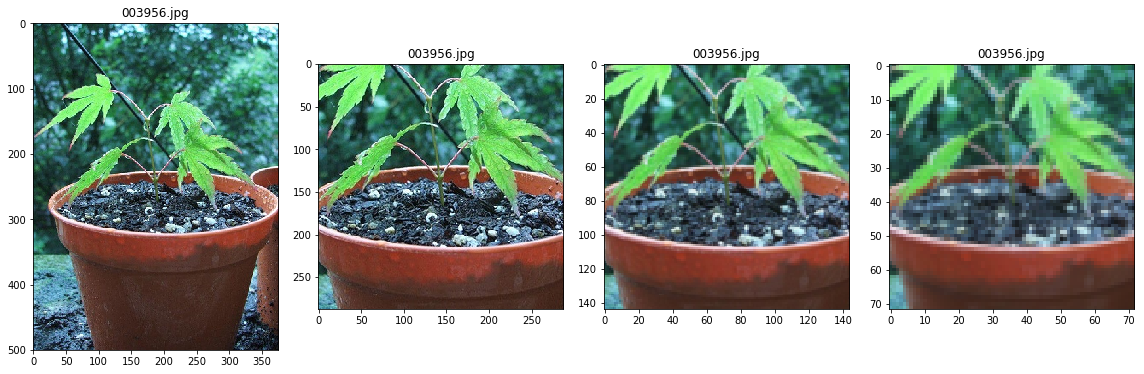

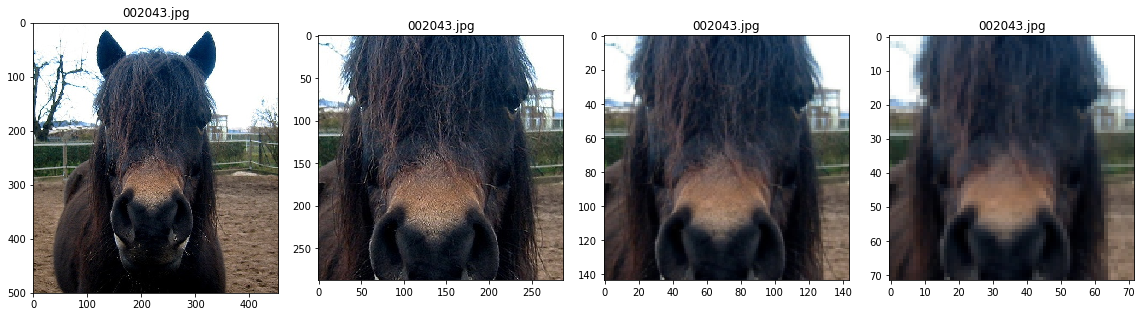

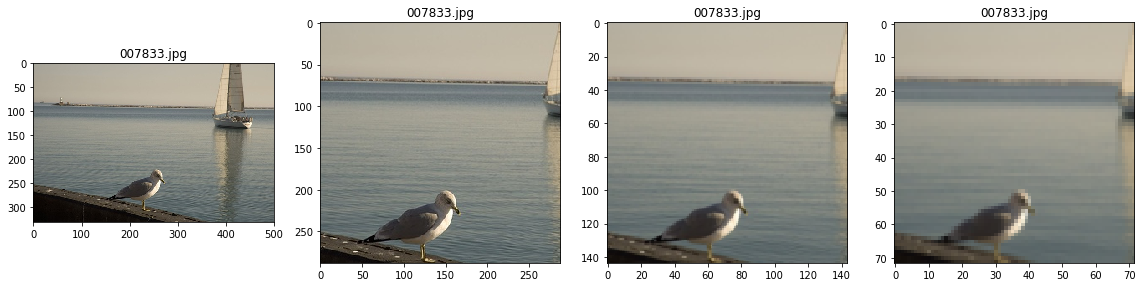

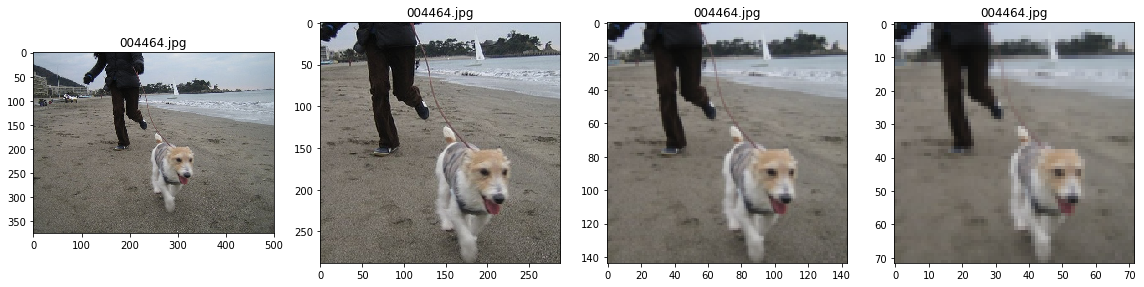

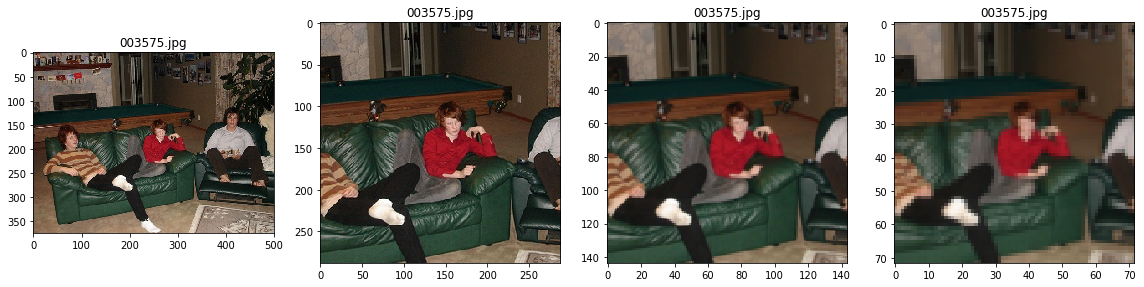

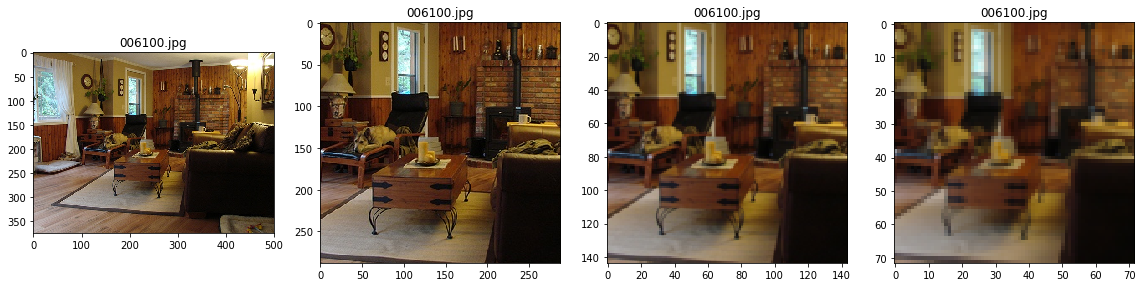

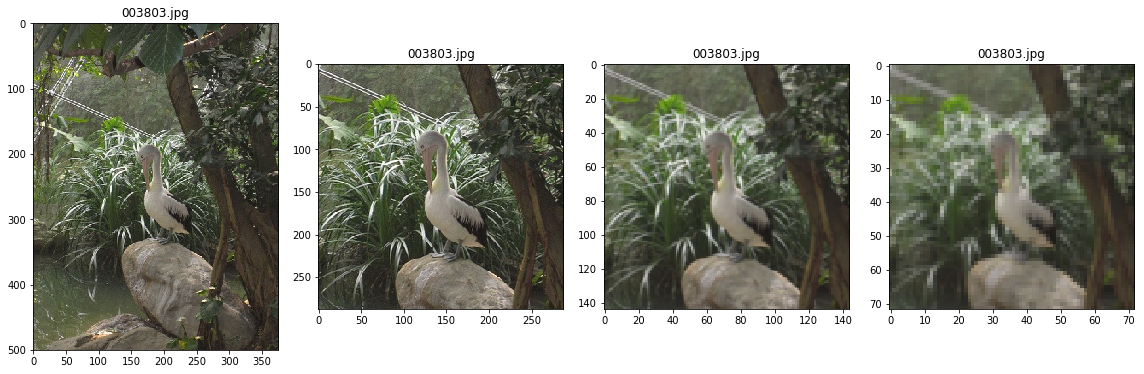

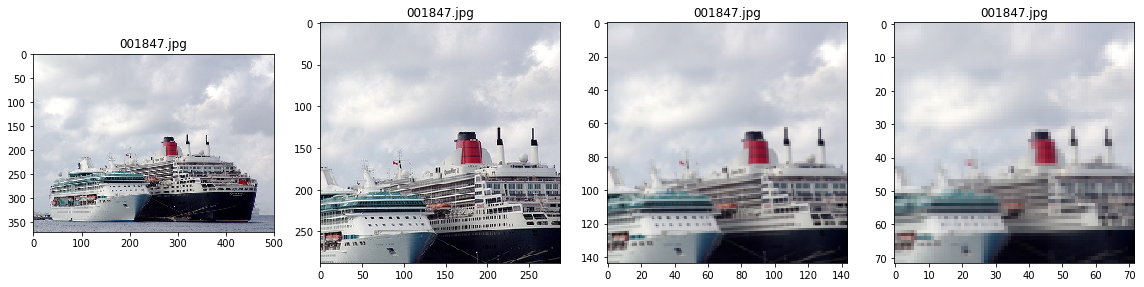

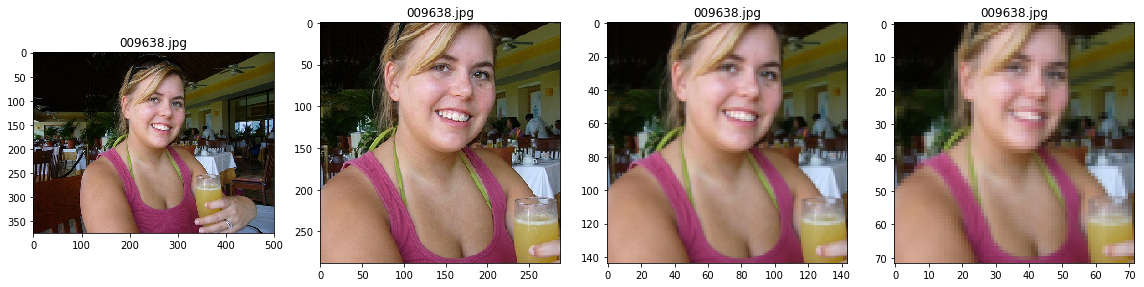

In [9]:
transform_288 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(288),
    transforms.ToTensor()
])

transform_144 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(288),
    transforms.Resize((144,144)),
    transforms.ToTensor()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_72 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(288),
    transforms.Resize((72,72)),
    transforms.ToTensor()
])



img_dataset_orig = ImageDataset(ORIG_IMAGE_DIR)
img_dataset_288 = ImageDataset(ORIG_IMAGE_DIR,transform=transform_288)
img_dataset_144 = ImageDataset(ORIG_IMAGE_DIR,transform=transform_144)
img_dataset_72 = ImageDataset(ORIG_IMAGE_DIR,transform=transform_72)


def show_img(img):
    #plt.figure(figsize=(18,15))
    # unnormalize
    #img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.show()
    
#img_dataset_orig[7].shape, img_dataset_288[7].shape, img_dataset_144[7].shape, img_dataset_72[7].shape
#plt.imshow(img_dataset_orig[7])
#plt.imshow(img_dataset_288[7])

#plt.imshow(img_dataset_orig[7])
#show_img(img_dataset_288[7])

def show_transforms(img_orig, img_288, img_144, img_72):
    plt.figure(figsize=(16,8))
    plt.subplot(1,4,1)
    plt.imshow(img_orig[1])
    plt.title(img_orig[0])
    plt.subplot(1,4,2)
    plt.title(img_288[0])
    show_img(img_288[1])
    plt.subplot(1,4,3)
    show_img(img_144[1])
    plt.title(img_144[0])
    plt.subplot(1,4,4)
    show_img(img_72[1])
    plt.title(img_72[0])
    plt.tight_layout()
    plt.show()


    
#show_transforms(img_dataset_orig[7],img_dataset_288[7],img_dataset_144[7],img_dataset_72[7])

#show_transforms(img_dataset_orig[2],img_dataset_288[2],img_dataset_144[2],img_dataset_72[2])

for i in range(10):
    show_transforms(img_dataset_orig[i],img_dataset_288[i],img_dataset_144[i],img_dataset_72[i])


In [11]:
%%time

#img_dataset_orig = ImageDataset(ORIG_IMAGE_DIR)
img_dataset_288 = ImageDataset(ORIG_IMAGE_DIR,transform=transform_288)
img_dataset_144 = ImageDataset(ORIG_IMAGE_DIR,transform=transform_144)
img_dataset_72 = ImageDataset(ORIG_IMAGE_DIR,transform=transform_72)

DEST_PATH = '/home/ubuntu/data/super-resolution/converted_images/'

#!mkdir DEST_PATH + 'small'
#!mkdir DEST_PATH + 'med'
#!mkdir DEST_PATH + 'large'

img_loader_288 = DataLoader(img_dataset_288)
for step, data in enumerate(img_loader_288):
    filename, img = data
    save_image(img, DEST_PATH + 'large/' + '288_' + filename[0] )

img_loader_144 = DataLoader(img_dataset_144)
for step, data in enumerate(img_loader_144):
    filename, img = data
    save_image(img, DEST_PATH + 'med/' + '144_' + filename[0] )
    
img_loader_72 = DataLoader(img_dataset_72)
for step, data in enumerate(img_loader_72):
    filename, img = data
    save_image(img, DEST_PATH + 'small/' + '72_' + filename[0] )
    

CPU times: user 2min 27s, sys: 2.17 s, total: 2min 29s
Wall time: 1min 25s


#### Check that we have the right number of files in each directory

In [12]:
! ls ~/data/super-resolution/converted_images/small/ | wc -l

5011


In [13]:
! ls ~/data/super-resolution/converted_images/med/ | wc -l

5011


In [14]:
! ls ~/data/super-resolution/converted_images/large/ | wc -l

5011


## Training and Validation Datasets and DataLoaders

These are the datasets/dataloaders that will be used in the training. The dataset combines the three size photos into a singe record.

We can create smaller dataset for dev by specifying DEV=True and the sizes for dev_train_size and dev_val_size.

In [21]:

ROOT_IMAGE_PATH = '/home/ubuntu/data/super-resolution/converted_images'

DEV = True
dev_train_size = 10
dev_val_size = 2


class SuperResDataset(Dataset):
    def __init__(self, root_images_folder_path, transform=None, is_train=False, dev_train_size=None, dev_val_size=None):
        super().__init__()
        self.root_images_folder_path = root_images_folder_path
        self.transform = transform
        self.is_train = is_train
        sorted_filenames_small = sorted(os.listdir(self.root_images_folder_path + '/small'))
        sorted_filenames_med = sorted(os.listdir(self.root_images_folder_path + '/med'))
        sorted_filenames_large = sorted(os.listdir(self.root_images_folder_path + '/large'))
        if is_train:
            if dev_train_size:
                self.image_files_small = sorted_filenames_small[1000:1000+dev_train_size]
                self.image_files_med = sorted_filenames_med[1000:1000+dev_train_size]
                self.image_files_large = sorted_filenames_large[1000:1000+dev_train_size]
            else:    
                self.image_files_small = sorted_filenames_small[1000:]
                self.image_files_med = sorted_filenames_med[1000:]
                self.image_files_large = sorted_filenames_large[1000:]
        else:
            if dev_val_size:
                self.image_files_small = sorted_filenames_small[:dev_val_size]
                self.image_files_med = sorted_filenames_med[:dev_val_size]
                self.image_files_large = sorted_filenames_large[:dev_val_size]
            else:    
                self.image_files_small = sorted_filenames_small[:1000]
                self.image_files_med = sorted_filenames_med[:1000]
                self.image_files_large = sorted_filenames_large[:1000]
        
    def __len__(self):
        return len(self.image_files_small)
    
    def __getitem__(self,idx):
        filenames = {}
        filenames['small'] = self.image_files_small[idx]
        filenames['med'] = self.image_files_med[idx]
        filenames['large'] = self.image_files_large[idx]
        
        image_path = os.path.join(self.root_images_folder_path + '/small', self.image_files_small[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        if not self.transform is None:
            img = self.transform(img)
        img_small = np.transpose(img,(2,0,1))
        
        
        image_path = os.path.join(self.root_images_folder_path + '/med', self.image_files_med[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        if not self.transform is None:
            img = self.transform(img)
        img_med = np.transpose(img,(2,0,1))

        image_path = os.path.join(self.root_images_folder_path + '/large', self.image_files_large[idx])  
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        if not self.transform is None:
            img = self.transform(img)
        img_large = np.transpose(img,(2,0,1))
        
        return filenames,img_small,img_med,img_large    
    

if DEV:
    train_ds = SuperResDataset(ROOT_IMAGE_PATH, is_train=True, dev_train_size=dev_train_size, dev_val_size=dev_val_size)
    val_ds = SuperResDataset(ROOT_IMAGE_PATH, is_train=False, dev_train_size=dev_train_size, dev_val_size=dev_val_size)        
else:    
    train_ds = SuperResDataset(ROOT_IMAGE_PATH, is_train=True)
    val_ds = SuperResDataset(ROOT_IMAGE_PATH, is_train=False)


print(len(train_ds), len(val_ds))

tr_loader = DataLoader(train_ds, batch_size=5)
val_loader = DataLoader(val_ds, batch_size=1)

#np.transpose(val_ds[0][1],(2,0,1)).shape


10 2


### Function to print a set of images

torch.Size([1, 3, 72, 72])


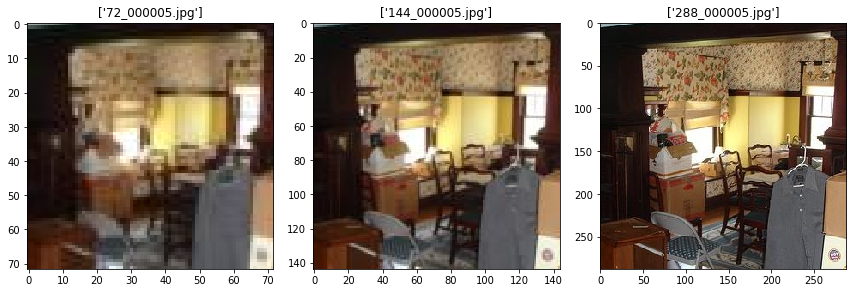

torch.Size([1, 3, 72, 72])


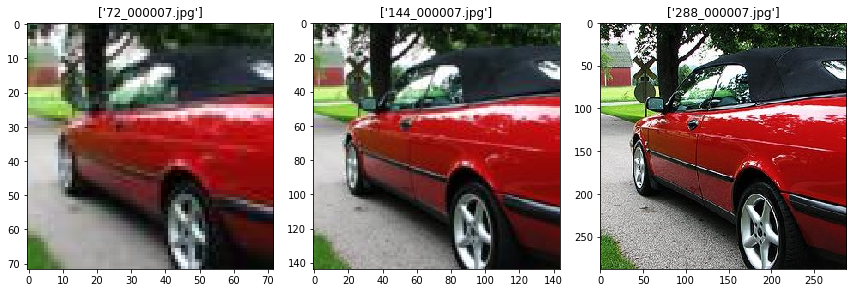

In [22]:
def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    #plt.show()

def show_3_images(labels,img1, img2, img3):
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    show_img(img1)
    plt.title(labels['small'])
    plt.subplot(1,3,2)
    show_img(img2)
    plt.title(labels['med'])
    plt.subplot(1,3,3)
    show_img(img3)
    plt.title(labels['large'])
    plt.tight_layout()
    plt.show()
    

# Can print from the val loader    
for step,batch in enumerate(val_loader):
    filenames,img_small,img_med,img_large = batch
    print(img_small.shape)
    #print(filenames)
    #show_img(torch.squeeze(img_small))
    #show_img(torch.squeeze(img_med))
    #show_img(torch.squeeze(img_large))
    
    show_3_images(filenames, torch.squeeze(img_small), torch.squeeze(img_med), torch.squeeze(img_large)   )
    #show_img(torch.squeeze(img))
    #print(torch.squeeze(img).shape)
    
